<a href="https://colab.research.google.com/github/Parisasuchdev/outlier_detection/blob/main/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/outlier_detection

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/outlier_detection


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score


In [ ]:
df = pd.read_csv('CTG_Dataset.csv')
df.drop(['FileName', 'Date', 'SegFile'], axis=1, inplace=True) # replacing unnecessary records because they don't directly impact the results

# splitting data
X = df.drop(['NSP'], axis=1)
# since data is continuous, we can replace NaN values with mean
X = df.iloc[:, 0:21].copy()  # explicitly creates a copy of the DataFrame
X.fillna(X.mean(), inplace=True)  # apply .fillna() to the copy
# to impute most frequest values in categorical class
imputer = SimpleImputer(strategy='most_frequent')
df['NSP'] = imputer.fit_transform(df[['NSP']])
df['NSP'].isna().sum() # imputed none values
y = df['NSP']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-7.14742531e-01, -1.44711102e+00, -1.35317378e+00, ...,
        -7.01891544e-01, -4.58767156e-01, -1.06636541e+00],
       [-9.77828410e-01, -1.15142615e+00, -1.32619068e-01, ...,
         6.55598947e-01,  9.58876702e-01,  2.16790942e-01],
       [-7.85271937e-01, -9.93369149e-01, -3.09061752e-02, ...,
         3.16226324e-01,  9.58876702e-01,  2.16790942e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -7.86950426e-17,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -7.86950426e-17,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -7.86950426e-17,  0.00000000e+00]])

While standardization and normalization are both methods of scaling data, they use different transformations to achieve different scales. Which method is more appropriate depends on the specific problem and the requirements of the machine learning algorithm being used. In general, standardization is more commonly used for clustering algorithms like DBSCAN, while normalization may be more appropriate for some classification algorithms that require features to be between 0 and 1.

# Models

we will test methods using PCA and without using PCA and evaluating by calculating f1 score

but we are also calculting the outlier detection using PCA

## Dimensionality Reduction
### PCA


[0.25067146 0.13746822]


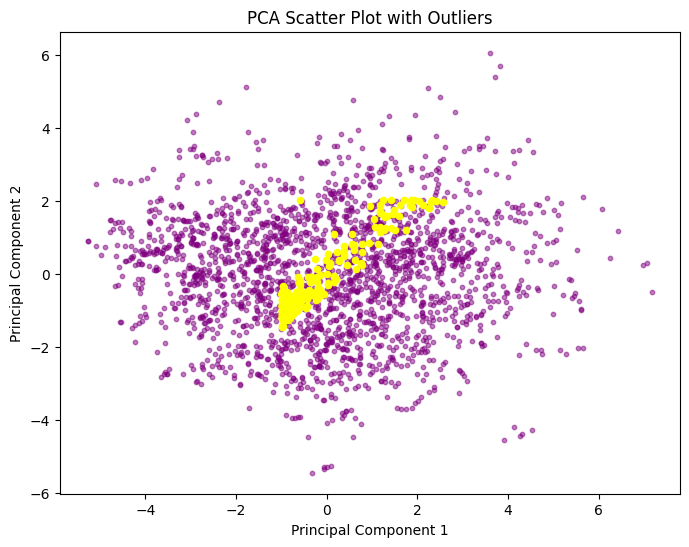

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# identifying outliers
outliers = X[np.where(np.logical_or(X_pca[:, 0] > 3, X_pca[:, 1] > 3))] # setting up a threshold
print(pca.explained_variance_ratio_) # shows the percentage covered by two components


# plotting the data and outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Classification Methods:

Isolation Forest and One-Class SVM are also anomaly detection methods that are derived from classification methods.

Isolation Forest is a tree-based ensemble method that randomly selects features and splits to isolate anomalous observations. The idea behind Isolation Forest is that anomalous observations are more easily separable from the rest of the data points and can be identified by a smaller number of splits.

One-Class SVM, on the other hand, is a Support Vector Machine-based method that learns a decision boundary that encompasses the entire normal data space. Any data point that falls outside of this boundary is considered an anomaly.



### OneClass SVM
first - without PCA
second - with PCA

0.6783852631458193


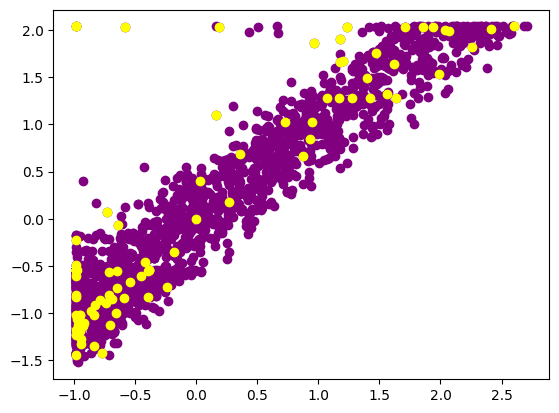

In [ ]:
# create OneClassSVM estimator
clf = OneClassSVM(kernel='rbf', nu=0.05)
clf.fit(X)
# predict labels for all data
y_pred = clf.predict(X)
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)
# identify outliers
outliers = X[y_pred == -1] # only get rows where y_pred == -1

# plot outliers
plt.scatter(X[:, 0], X[:, 1], c='purple')
plt.scatter(outliers[:, 0], outliers[:, 1], c='yellow')
plt.show()

0.6787536504730773


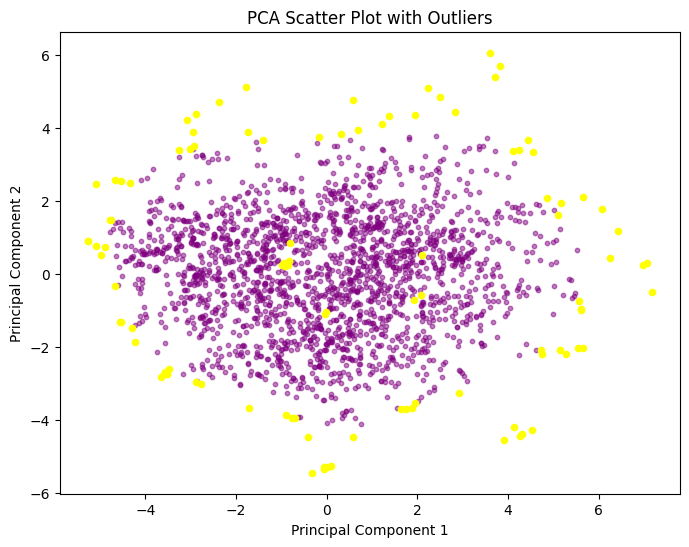

In [ ]:
# create OneClassSVM estimator
clf = OneClassSVM(kernel='rbf', nu=0.05)
clf.fit(X_pca)
# predict labels for all data
y_pred = clf.predict(X_pca)
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)
# identify outliers
outliers = X_pca[y_pred == -1] # only get rows where y_pred == -1

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

### Isolation Forest

0.6768362109881247


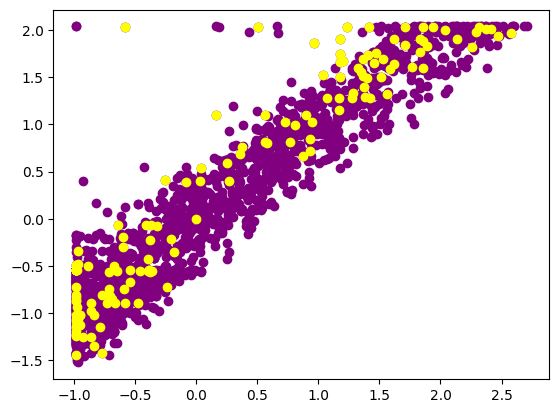

In [ ]:
# perform isolation forest outlier detection
clf = IsolationForest()
clf.fit(X)
y_pred = clf.predict(X)
outliers = X[y_pred == -1]
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)

# plot outliers
plt.scatter(X[:, 0], X[:, 1], c='purple')
plt.scatter(outliers[:, 0], outliers[:, 1], c='yellow')
plt.show()

0.6568218128987444


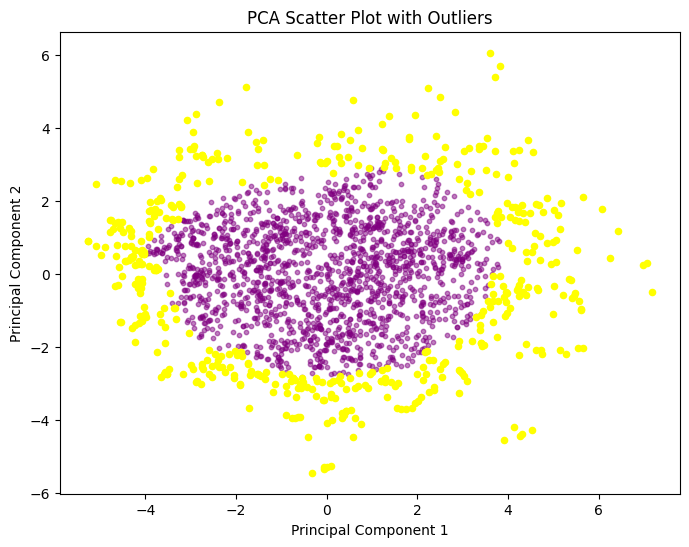

In [ ]:
# perform isolation forest outlier detection
clf = IsolationForest()
clf.fit(X_pca)
y_pred = clf.predict(X_pca)
outliers = X_pca[y_pred == -1]
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Density based methods
### LOF

LOF (Local Outlier Factor) is also an anomaly detection method, but it's a density-based approach. It determines the local density of a data point relative to its neighbors, and assigns an outlier score based on how much smaller the density of the point is compared to its neighbors. A point that has a much lower density than its neighbors is considered an outlier. LOF is based on the assumption that outliers are not only far from the center of the data, but also far from their surrounding neighbors. LOF has been shown to perform well on high-dimensional data and can handle noise and varying densities in the data.

0.6589251793194574


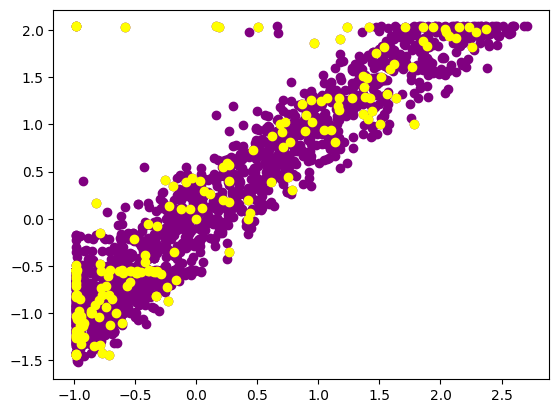

In [ ]:
# perform LOF outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X)
outliers = X[y_pred == -1]

# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)

# plot outliers
plt.scatter(X[:, 0], X[:, 1], c='purple')
plt.scatter(outliers[:, 0], outliers[:, 1], c='yellow')
plt.show()

0.6789718448278536


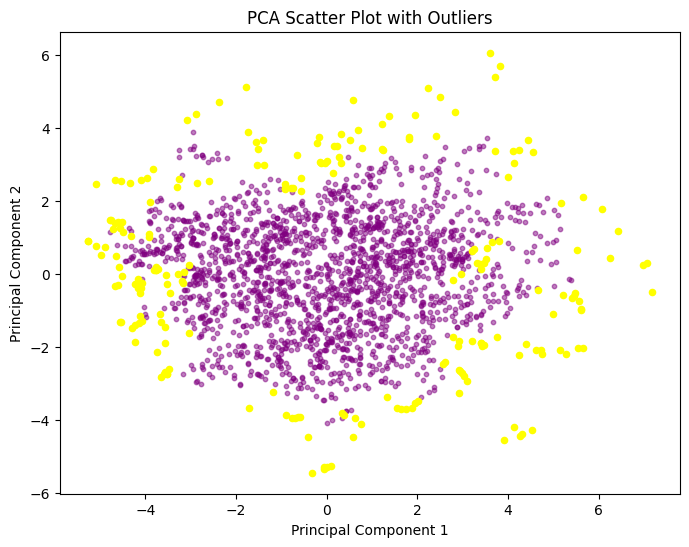

In [ ]:
# perform LOF outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X_pca)
outliers = X_pca[y_pred == -1]

# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f1)

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Clustering Based Methods

### DBSCAN

0.3521443973237593


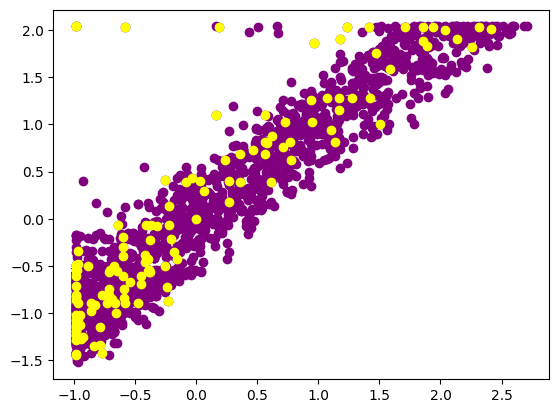

In [ ]:
from sklearn import metrics

dbscan = DBSCAN(eps=3, min_samples=10)
y_pred = dbscan.fit_predict(X)
outliers = X[y_pred == -1]

silhouette_score = metrics.silhouette_score(X, y_pred)
print(silhouette_score)

# plot outliers
plt.scatter(X[:, 0], X[:, 1], c='purple')
plt.scatter(outliers[:, 0], outliers[:, 1], c='yellow')
plt.show()

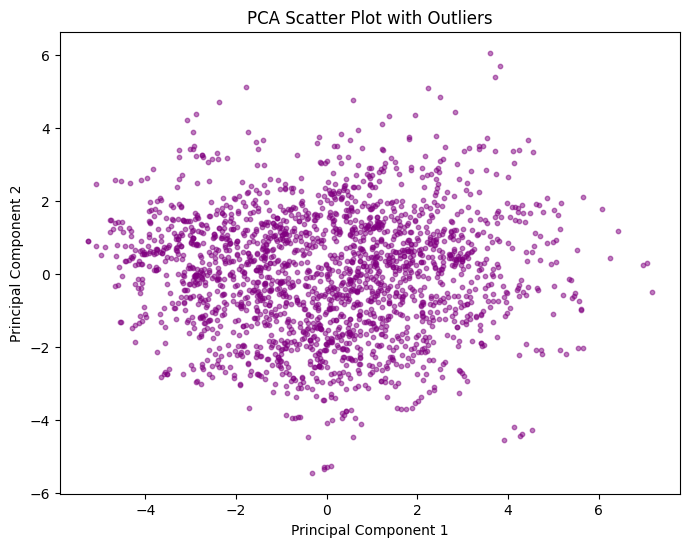

In [ ]:
from sklearn import metrics

dbscan = DBSCAN(eps=3, min_samples=10)
y_pred = dbscan.fit_predict(X_pca)
outliers = X_pca[y_pred == -1]

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()
